In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deepcad-rt-demo/01_ZebrafishOT_GCaMP6s_492x492x6955_lowSNR.tif
/kaggle/input/deepcad-rt-demo/01_ZebrafishOT_GCaMP6s_492x492x6955_highSNR.tif


# Convert to NWB format

In [2]:
! pip install -U pynwb -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 339.5/339.5 kB 14.4 MB/s eta 0:00:00


In [3]:
from datetime import datetime
import os
from uuid import uuid4

import numpy as np
from dateutil import tz
from PIL import Image
from datetime import datetime
import tifffile

from pynwb import NWBHDF5IO, NWBFile
from pynwb.base import Images
from pynwb.image import GrayscaleImage, ImageSeries, OpticalSeries, RGBAImage, RGBImage
from pynwb.misc import AbstractFeatureSeries

# Define file paths used in the tutorial
nwbfile_path = os.path.abspath("01_ZebrafishOT_GCaMP6s_492x492x6955.nwb")
moviefiles_path = [
    os.path.abspath("/kaggle/input/deepcad-rt-demo/01_ZebrafishOT_GCaMP6s_492x492x6955_highSNR.tif"),
    os.path.abspath("/kaggle/input/deepcad-rt-demo/01_ZebrafishOT_GCaMP6s_492x492x6955_lowSNR.tif"),
]

In [4]:
session_start_time = datetime(2018, 4, 25, 2, 30, 3, tzinfo=tz.gettz("US/Pacific"))

nwbfile = NWBFile(
    session_description="Calcium imaging experiment",
    identifier=str(uuid4()),
    session_start_time=session_start_time,
    experimenter="cabooster",
    institution="Institute of Brain and Intelligence, Hangzhou, China",
    experiment_description="Raw calcium imaging stack",
    related_publications="https://doi.org/10.1038/s41587-022-01450-8"
)

nwbfile

root pynwb.file.NWBFile at 0x135690413606544
Fields:
  experiment_description: Raw calcium imaging stack
  experimenter: ['cabooster']
  file_create_date: [datetime.datetime(2025, 11, 17, 15, 30, 20, 816956, tzinfo=tzlocal())]
  identifier: 8655c58a-cbec-4adc-a618-073aaa95d2d5
  institution: Institute of Brain and Intelligence, Hangzhou, China
  related_publications: ['https://doi.org/10.1038/s41587-022-01450-8']
  session_description: Calcium imaging experiment
  session_start_time: 2018-04-25 02:30:03-07:00
  timestamps_reference_time: 2018-04-25 02:30:03-07:00

In [5]:
from pynwb.device import Device
from pynwb.ophys import OpticalChannel, ImagingPlane
from pynwb.file import Subject

if "Two-photon microscope" in nwbfile.devices:
    device = nwbfile.devices["Two-photon microscope"]
else:
    device = nwbfile.create_device(name="Two-photon microscope")

optical_channel = OpticalChannel(
    name="OpticalChannel",
    description="GCaMP6f emission",
    emission_lambda=510.0
)
plane_name = "Zebrafish optic tectum neurons with Calcium transient event"
if plane_name in nwbfile.imaging_planes:
    imaging_plane = nwbfile.imaging_planes[plane_name]
else:
    imaging_plane = nwbfile.create_imaging_plane(
        name=plane_name,
        optical_channel=optical_channel,
        description="pixel size 0.254 µm/px, depth 40 µm",
        device=device,
        excitation_lambda=920.0,
        indicator="GCaMP6f",
        location="tectum neurons",
        imaging_rate=30.0
    )



In [6]:
# Load stack: shape (frames, height, width)
highSNR_data = tifffile.imread("/kaggle/input/deepcad-rt-demo/01_ZebrafishOT_GCaMP6s_492x492x6955_highSNR.tif")

# Load stack: shape (frames, height, width)
lowSNR_data = tifffile.imread("/kaggle/input/deepcad-rt-demo/01_ZebrafishOT_GCaMP6s_492x492x6955_lowSNR.tif")
print(lowSNR_data.shape)


(6955, 492, 492)


In [7]:
session_start_time = datetime(2018, 4, 25, 2, 30, 3, tzinfo=tz.gettz("US/Pacific"))

from pynwb.ophys import TwoPhotonSeries

high_snr_series = TwoPhotonSeries(
    name="TwoPhotonSeries_HighSNR",
    imaging_plane=imaging_plane,
    data=highSNR_data,   # numpy array from tifffile.imread
    unit="a.u.",
    rate=30.0,
    description="High-SNR acquisition path"
)

low_snr_series = TwoPhotonSeries(
    name="TwoPhotonSeries_LowSNR",
    imaging_plane=imaging_plane,
    data=lowSNR_data,
    unit="a.u.",
    rate=30.0,
    description="Low-SNR acquisition path"
)

nwbfile.add_acquisition(high_snr_series)
nwbfile.add_acquisition(low_snr_series)


In [8]:
with NWBHDF5IO("ZebrafishOT.nwb", "w") as io:
    io.write(nwbfile)


In [9]:
with NWBHDF5IO("ZebrafishOT.nwb", "r") as io:
    read_nwbfile = io.read()
    print(read_nwbfile.acquisition["TwoPhotonSeries_LowSNR"].data.shape)
    print(read_nwbfile.acquisition["TwoPhotonSeries_HighSNR"].data.shape)

(6955, 492, 492)
(6955, 492, 492)


# Suite2p Full Calcium Imaging Pipeline

In [10]:
!pip install --upgrade suite2p -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.3 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.3/662.3 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.5/90.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.0 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━

In [11]:
from pathlib import Path
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt
import numpy as np

import suite2p

In [12]:
# Figure Style settings for notebook.
import matplotlib as mpl
mpl.rcParams.update({
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
    'figure.subplot.wspace': .01,
    'figure.subplot.hspace': .01,
    'figure.figsize': (18, 13),
    'ytick.major.left': False,
})
jet = mpl.cm.get_cmap('jet')
jet.set_bad(color='k')

/tmp/ipykernel_48/1242306857.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = mpl.cm.get_cmap('jet')


In [13]:
ops = suite2p.default_ops()
print(ops)

{'suite2p_version': '0.14.6', 'look_one_level_down': False, 'fast_disk': [], 'delete_bin': False, 'mesoscan': False, 'bruker': False, 'bruker_bidirectional': False, 'h5py': [], 'h5py_key': 'data', 'nwb_file': '', 'nwb_driver': '', 'nwb_series': '', 'save_path0': '', 'save_folder': [], 'subfolders': [], 'move_bin': False, 'nplanes': 1, 'nchannels': 1, 'functional_chan': 1, 'tau': 1.0, 'fs': 10.0, 'force_sktiff': False, 'frames_include': -1, 'multiplane_parallel': False, 'ignore_flyback': [], 'preclassify': 0.0, 'save_mat': False, 'save_NWB': False, 'combined': True, 'aspect': 1.0, 'do_bidiphase': False, 'bidiphase': 0, 'bidi_corrected': False, 'do_registration': True, 'two_step_registration': False, 'keep_movie_raw': False, 'nimg_init': 300, 'batch_size': 500, 'maxregshift': 0.1, 'align_by_chan': 1, 'reg_tif': False, 'reg_tif_chan2': False, 'subpixel': 10, 'smooth_sigma_time': 0, 'smooth_sigma': 1.15, 'th_badframes': 1.0, 'norm_frames': True, 'force_refImg': False, 'pad_fft': False, 'no


# Configure Suite2p ops for zebrafish optic tectum two-photon calcium imaging with GCaMP6s.

Key parameters:
- fs (float): Sampling rate in Hz. Set to the actual frame rate (e.g., 30.0).
- tau (float): Sensor decay time constant. For GCaMP6s use ~1.25–1.35 to match kinetics.
- diameter (int): Approximate soma size in pixels. Convert soma size (~6–10 µm) using pixel size (0.254 µm/px).
- nonrigid (bool): Enable non-rigid registration to correct local motion artifacts.
- block_size (list): Patch size for non-rigid registration. Adjust based on FOV and motion (e.g., [128,128]).
- high_pass (int): Temporal high-pass filter cutoff (Hz). Use ~60–80 for stable traces at 30 Hz.
- neuropil_extract (bool): Enable neuropil subtraction to reduce background contamination.
- inner_neuropil_radius (int): Radius around soma excluded from neuropil mask (2–4 px for ~30 px soma).
- neucoeff (float): Neuropil subtraction coefficient. Start at 0.7 and adjust based on SNR.
- baseline (str): Method for baseline estimation. "maximin" is robust for long recordings.
- win_baseline (float): Window length in seconds for baseline calculation (e.g., 120.0).

General notes:
- Always match fs and tau to your imaging setup and sensor kinetics.
- Tune diameter and neuropil parameters to soma size and pixel resolution.
- Validate registration and ROI masks visually; adjust block_size or diameter if segmentation is poor.
- Sweep tau values (1.25–1.35) to optimize deconvolution fidelity for GCaMP6s.



In [14]:

print(ops)

{'suite2p_version': '0.14.6', 'look_one_level_down': False, 'fast_disk': [], 'delete_bin': False, 'mesoscan': False, 'bruker': False, 'bruker_bidirectional': False, 'h5py': [], 'h5py_key': 'data', 'nwb_file': '', 'nwb_driver': '', 'nwb_series': '', 'save_path0': '', 'save_folder': [], 'subfolders': [], 'move_bin': False, 'nplanes': 1, 'nchannels': 1, 'functional_chan': 1, 'tau': 1.0, 'fs': 10.0, 'force_sktiff': False, 'frames_include': -1, 'multiplane_parallel': False, 'ignore_flyback': [], 'preclassify': 0.0, 'save_mat': False, 'save_NWB': False, 'combined': True, 'aspect': 1.0, 'do_bidiphase': False, 'bidiphase': 0, 'bidi_corrected': False, 'do_registration': True, 'two_step_registration': False, 'keep_movie_raw': False, 'nimg_init': 300, 'batch_size': 500, 'maxregshift': 0.1, 'align_by_chan': 1, 'reg_tif': False, 'reg_tif_chan2': False, 'subpixel': 10, 'smooth_sigma_time': 0, 'smooth_sigma': 1.15, 'th_badframes': 1.0, 'norm_frames': True, 'force_refImg': False, 'pad_fft': False, 'no

In [15]:
os.getcwd()

'/kaggle/working'


# Suite2p NWB configuration:
- nwb_file: Path to NWB file containing imaging data.
- nwb_series: Acquisition key inside NWB (e.g., 'TwoPhotonSeries_HighSNR').
- save_path0: Output directory for Suite2p results.
Other db fields (h5py, tiff, fast_disk) are not needed when using NWB.


In [16]:
#***************If you want to use your tiff file you can uncomment this part*************
# db = {
#     'data_path': ['/kaggle/input/deepcad-rt-demo'],
#     'save_path0': TemporaryDirectory().name,
#     'tiff_list': ['01_ZebrafishOT_GCaMP6s_492x492x6955_highSNR.tif'],
# }
# db



In [17]:
#***************If you want to use your tiff file you can uncomment this part*************
# db = {
#     'data_path': ['/kaggle/input/deepcad-rt-demo'],
#     'save_path0': TemporaryDirectory().name,
#     'tiff_list': ['01_ZebrafishOT_GCaMP6s_492x492x6955_highSNR.tif'],
# }
# db

db = {
    'data_path': ['/kaggle/working/'],                  # dummy path; Suite2p requires this key
    'nwb_file': 'ZebrafishOT.nwb',       # your NWB file
    'nwb_series': 'TwoPhotonSeries_HighSNR',  # acquisition key
    'save_path0': '/kaggle/working/'
}
db

{'data_path': ['/kaggle/working/'],
 'nwb_file': 'ZebrafishOT.nwb',
 'nwb_series': 'TwoPhotonSeries_HighSNR',
 'save_path0': '/kaggle/working/'}

In [18]:
output_ops = suite2p.run_s2p(ops=ops, db=db)

{'data_path': ['/kaggle/working/'], 'nwb_file': 'ZebrafishOT.nwb', 'nwb_series': 'TwoPhotonSeries_HighSNR', 'save_path0': '/kaggle/working/'}
2000 frames of binary, time 8.77 sec.
4000 frames of binary, time 28.51 sec.
6000 frames of binary, time 41.46 sec.
time 46.46 sec. Wrote 6955 frames per binary for 1 planes
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not registered / registration forced with ops['do_registration']>1
      (no previous offsets to delete)
NOTE: Applying builtin classifier at /usr/local/lib/python3.11/dist-packages/suite2p/classifiers/classifier.npy
----------- REGISTRATION
Reference frame, 27.39 sec.
Registered 500/6955 in 26.43s
Registered 1000/6955 in 46.85s
Registered 1500/6955 in 67.55s
Registered 2000/6955 in 87.31s
Registered 2500/6955 in 108.67s
Registered 3000/6955 in 128.90s
Registered 3500/6955 in 150.95s
Registered 4000/6955 in 170.68s
Registered 4500/6955 in 191.14s
Registered 5000/6955 in 211.88s
Registered 5500/6955 in 232.44s
Register

/usr/local/lib/python3.11/dist-packages/suite2p/extraction/extract.py:125: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  Fi[n] = np.dot(data[:, cell_ipix[n]], cell_lam[n])


Extracted fluorescence from 188 ROIs in 6955 frames, 15.11 sec.
----------- Total 17.69 sec.
----------- CLASSIFICATION
['compact', 'skew', 'npix_norm']
----------- SPIKE DECONVOLUTION
----------- Total 0.13 sec.
Plane 0 processed in 427.62 sec (can open in GUI).
total = 474.41 sec.
TOTAL RUNTIME 474.41 sec


In [19]:
len(output_ops)

127

In [20]:
output_op = output_ops
print(set(output_op.keys()).difference(ops.keys()))

{'regPC', 'data_path', 'Lyc', 'corrXY', 'ihop', 'max_proj', 'Ly', 'ops_path', 'reg_file', 'regDX', 'meanImg', 'rmax', 'Lx', 'Lxc', 'corrXY1', 'xoff1', 'yrange', 'xrange', 'save_path', 'rmin', 'yoff1', 'date_proc', 'badframes', 'Vcorr', 'refImg', 'frames_per_file', 'Vsplit', 'frames_per_folder', 'Vmap', 'yoff', 'spatscale_pix', 'meanImgE', 'xoff', 'input_format', 'nframes', 'Vmax', 'timing', 'tPC'}


In [21]:
list(Path(output_ops['save_path']).iterdir())

[PosixPath('/kaggle/working/suite2p/plane0/stat.npy'),
 PosixPath('/kaggle/working/suite2p/plane0/spks.npy'),
 PosixPath('/kaggle/working/suite2p/plane0/Fneu.npy'),
 PosixPath('/kaggle/working/suite2p/plane0/iscell.npy'),
 PosixPath('/kaggle/working/suite2p/plane0/F.npy'),
 PosixPath('/kaggle/working/suite2p/plane0/data.bin'),
 PosixPath('/kaggle/working/suite2p/plane0/ops.npy')]

In [22]:
output_op_file = np.load(Path(output_op['save_path']).joinpath('ops.npy'), allow_pickle=True).item()
output_op_file.keys() == output_op.keys()

True

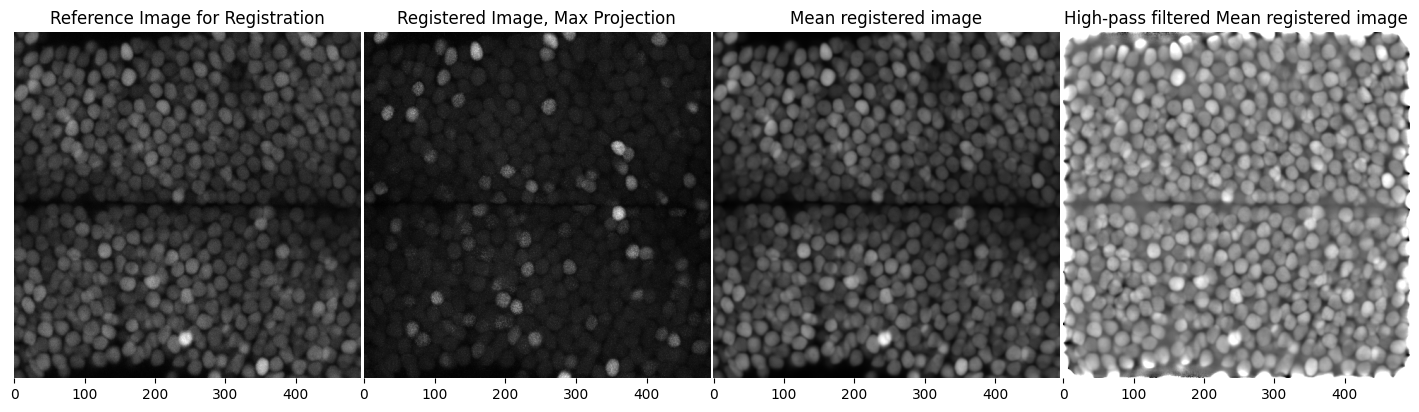

In [23]:
plt.subplot(1, 4, 1)
plt.imshow(output_ops['refImg'], cmap='gray', )
plt.title("Reference Image for Registration");

plt.subplot(1, 4, 2)
plt.imshow(output_ops['max_proj'], cmap='gray')
plt.title("Registered Image, Max Projection");

plt.subplot(1, 4, 3)
plt.imshow(output_ops['meanImg'], cmap='gray')
plt.title("Mean registered image")

plt.subplot(1, 4, 4)
plt.imshow(output_ops['meanImgE'], cmap='gray')
plt.title("High-pass filtered Mean registered image");

# Detection

In [24]:
stats_file = Path(output_ops['save_path']).joinpath('stat.npy')
iscell = np.load(Path(output_ops['save_path']).joinpath('iscell.npy'), allow_pickle=True)[:, 0].astype(bool)
stats = np.load(stats_file, allow_pickle=True)
stats.shape, iscell.shape

((188,), (188,))

In [25]:
output_ops['Ly']

492

/tmp/ipykernel_48/2986013853.py:9: RuntimeWarning: All-NaN slice encountered
  plt.imshow(np.nanmax(im, axis=0), cmap='jet')
/tmp/ipykernel_48/2986013853.py:13: RuntimeWarning: All-NaN slice encountered
  plt.imshow(np.nanmax(im[~iscell], axis=0, ), cmap='jet')
/tmp/ipykernel_48/2986013853.py:17: RuntimeWarning: All-NaN slice encountered
  plt.imshow(np.nanmax(im[iscell], axis=0), cmap='jet')
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


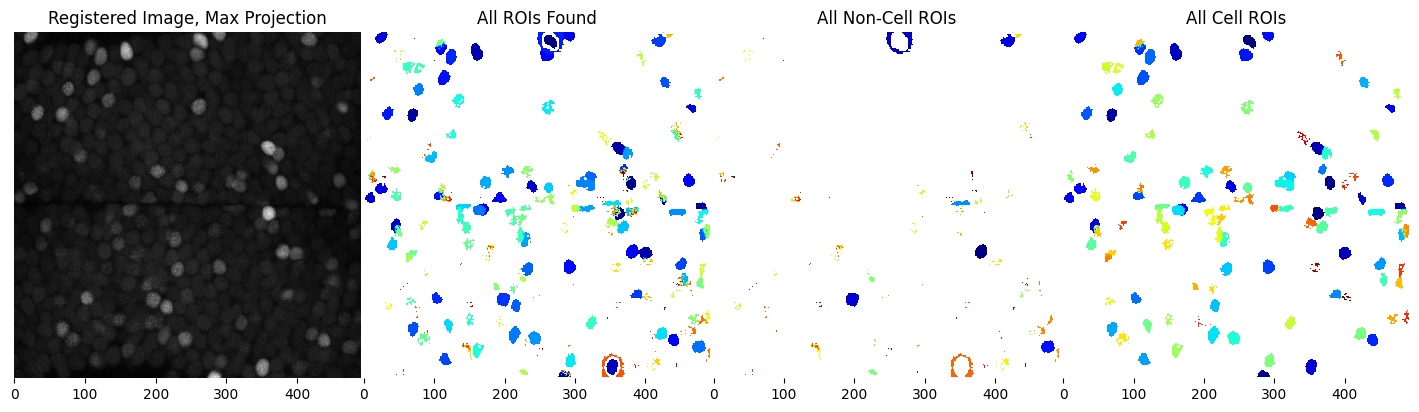

In [26]:
im = suite2p.ROI.stats_dicts_to_3d_array(stats, Ly=output_ops['Ly'], Lx=output_ops['Lx'], label_id=True)
im[im == 0] = np.nan

plt.subplot(1, 4, 1)
plt.imshow(output_ops['max_proj'], cmap='gray')
plt.title("Registered Image, Max Projection")

plt.subplot(1, 4, 2)
plt.imshow(np.nanmax(im, axis=0), cmap='jet')
plt.title("All ROIs Found")

plt.subplot(1, 4, 3)
plt.imshow(np.nanmax(im[~iscell], axis=0, ), cmap='jet')
plt.title("All Non-Cell ROIs")

plt.subplot(1, 4, 4)
plt.imshow(np.nanmax(im[iscell], axis=0), cmap='jet')
plt.title("All Cell ROIs");

In [27]:
print("Number of ROIs:", len(stats))
print("Number classified as cells:", iscell.sum())
print("Number classified as non-cells:", (~iscell).sum())


Number of ROIs: 188
Number classified as cells: 110
Number classified as non-cells: 78


# Extract Traces

In [28]:
import numpy as np
from pathlib import Path

suite2p_dir = Path(output_ops['save_path'])

F = np.load(suite2p_dir / "F.npy")         # shape: (nROIs, nFrames)
Fneu = np.load(suite2p_dir / "Fneu.npy")   # shape: (nROIs, nFrames)
spks = np.load(suite2p_dir / "spks.npy")   # shape: (nROIs, nFrames)
iscell = np.load(suite2p_dir / "iscell.npy", allow_pickle=True)[:, 0].astype(bool)
stat = np.load(suite2p_dir / "stat.npy", allow_pickle=True)
ops = np.load(suite2p_dir / "ops.npy", allow_pickle=True).item()

# f_cells = np.load(Path(output_ops['save_path']).joinpath('F.npy'))
# f_neuropils = np.load(Path(output_ops['save_path']).joinpath('Fneu.npy'))
# spks = np.load(Path(output_ops['save_path']).joinpath('spks.npy'))
# f_cells.shape, f_neuropils.shape, spks.shape
F.shape, Fneu.shape, spks.shape, iscell.shape, stat.shape

((188, 6955), (188, 6955), (188, 6955), (188,), (188,))

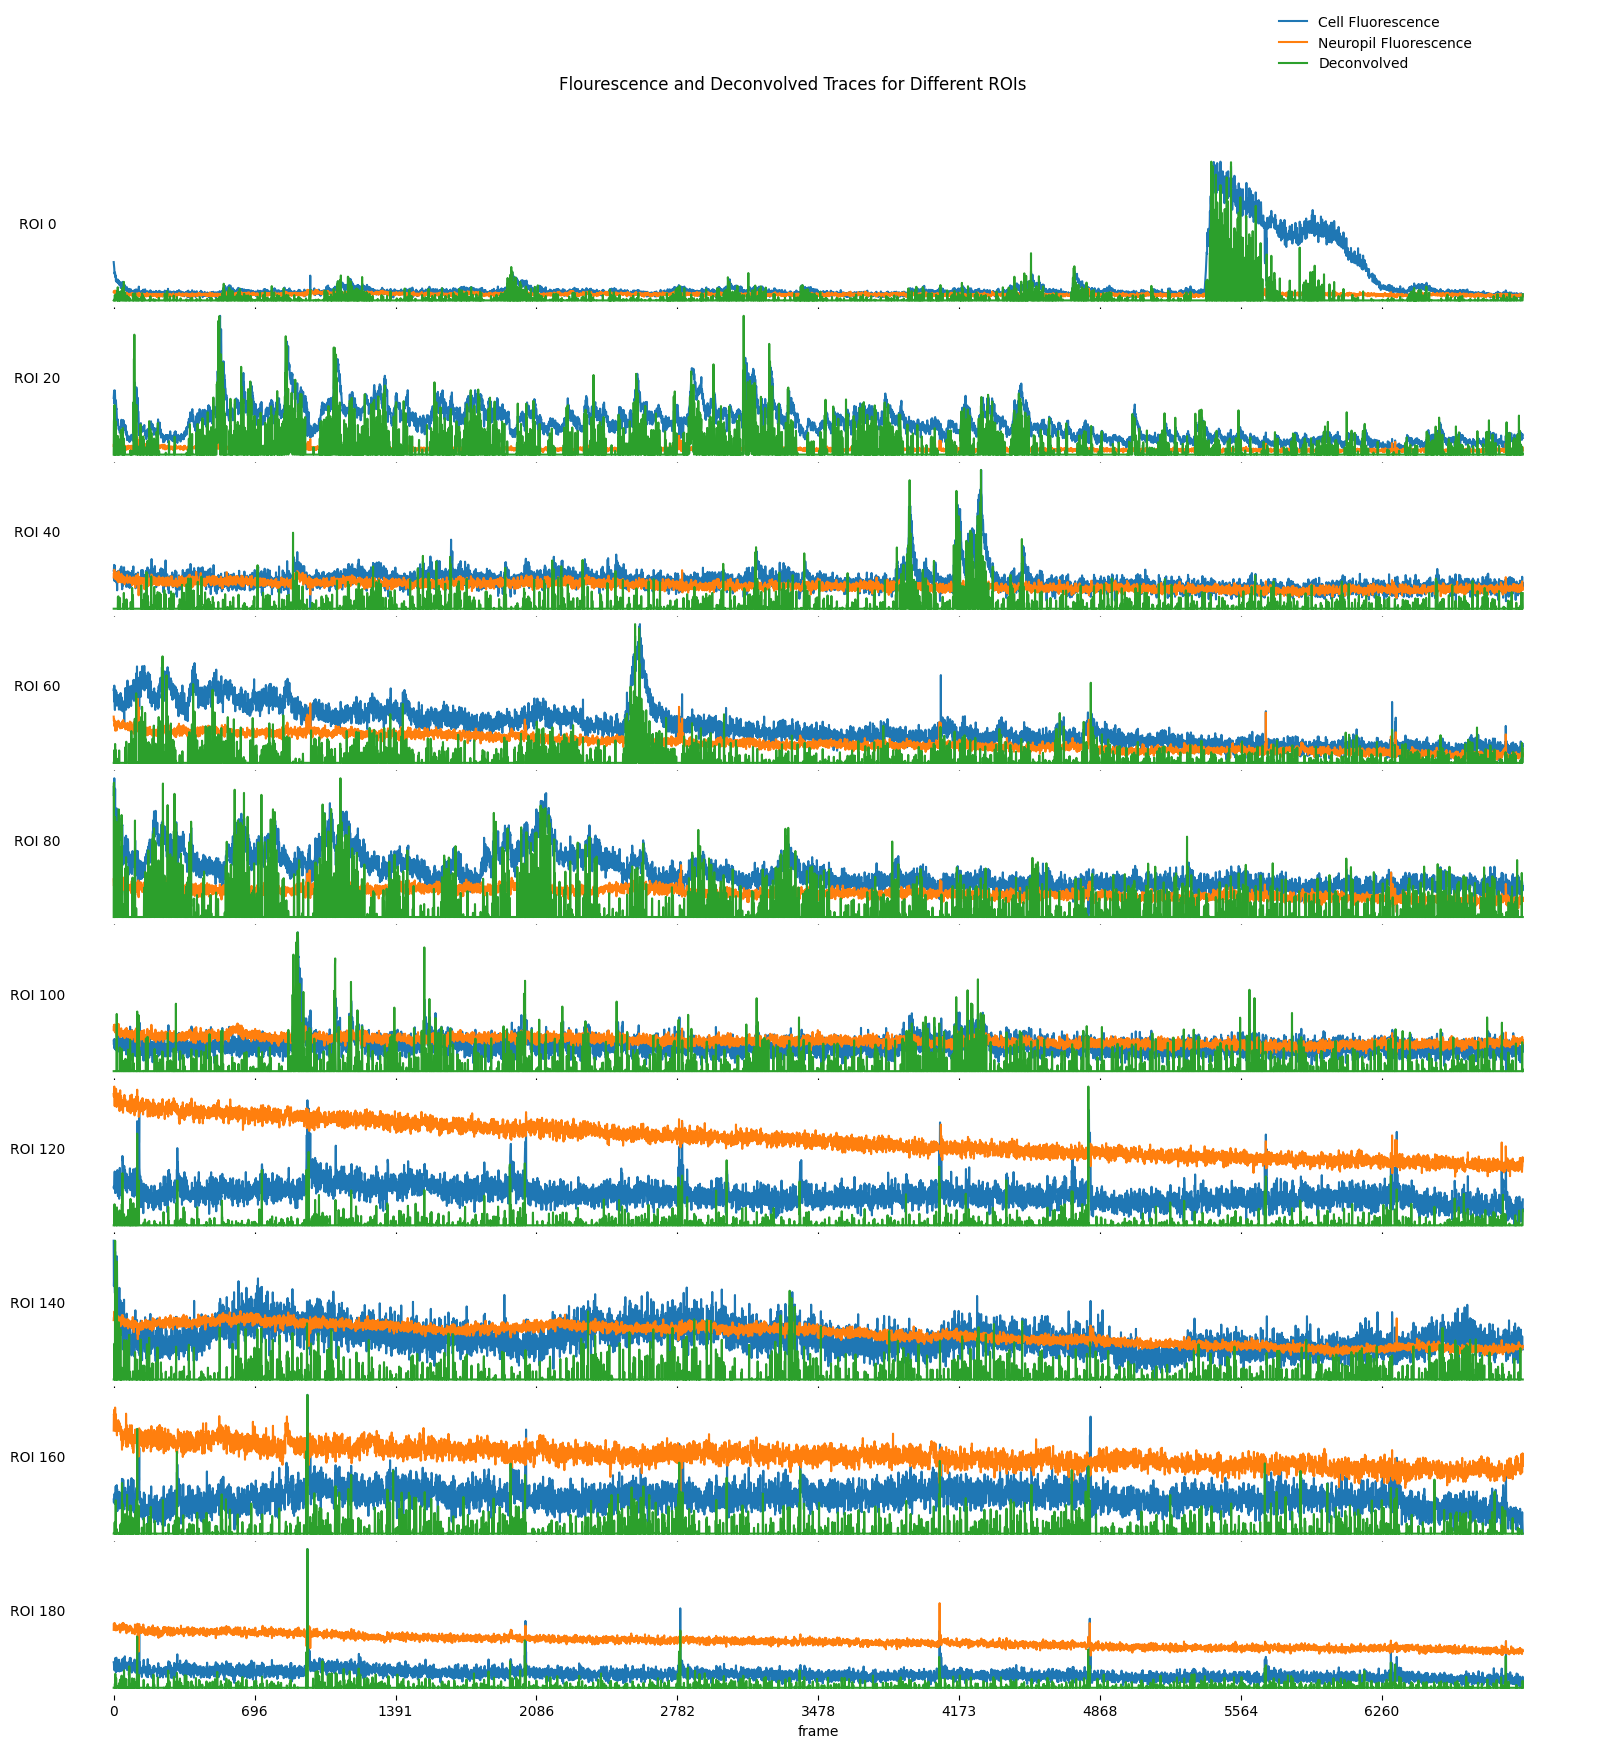

In [29]:
plt.figure(figsize=[20,20])
plt.suptitle("Flourescence and Deconvolved Traces for Different ROIs", y=0.92);
rois = np.arange(len(F))[::20]
for i, roi in enumerate(rois):
    plt.subplot(len(rois), 1, i+1, )
    f = F[roi]
    f_neu = Fneu[roi]
    sp = spks[roi]
    # Adjust spks range to match range of fluroescence traces
    fmax = np.maximum(f.max(), f_neu.max())
    fmin = np.minimum(f.min(), f_neu.min())
    frange = fmax - fmin 
    sp /= sp.max()
    sp *= frange
    plt.plot(f, label="Cell Fluorescence")
    plt.plot(f_neu, label="Neuropil Fluorescence")
    plt.plot(sp + fmin, label="Deconvolved")
    plt.xticks(np.arange(0, F.shape[1], F.shape[1]/10))
    plt.ylabel(f"ROI {roi}", rotation=0)
    plt.xlabel("frame")
    if i == 0:
        plt.legend(bbox_to_anchor=(0.93, 2))